# Buy or "Bye" project
**Daryush Ray; Afet Ibadova**



## Overview
This Jupyter Notebook is part of the "Buy or Bye" project which aims to develop, optimize, and test two distinct investment strategies using the Python programming language. The project focuses on historical stock data from NVIDIA, sourced from Yahoo Finance, covering the period from January 2018 to January 2024.

## Objectives
The primary objectives of this notebook are:
1. **Implement** two trading strategies:
   - A technical indicator-based strategy using Exponential Moving Average (EMA) crossovers.
   - A machine learning-based strategy using models such as Random Forest and XGBoost.
2. **Optimize** these strategies to enhance their performance in terms of profitability and risk management.
3. **Test** the strategies on historical data to validate their effectiveness in real-world trading scenarios.

## Strategies Overview
- **Strategy 1: EMA Crossover**
  - This strategy generates buy signals when a short-term EMA (12 days) crosses above a long-term EMA (26 days) and sell signals when it crosses below.
  
- **Strategy 2: Machine Learning Models**
  - This strategy utilizes a combination of machine learning algorithms to predict stock price movements based on features like moving averages, momentum indicators, and relative strength index (RSI).

## Data Description
The dataset includes daily trading information such as opening price, closing price, high, low, and volume of NVIDIA stocks. The data is split into two segments: 80% of the dataset for training and the remaining 20% for testing

## Notebook Setup
Below are the Python libraries and modules we will be using:
- `pandas` for data manipulation and analysis.
- `numpy` for numerical operations.
- `matplotlib` and `seaborn` for data visualization.
- `sklearn` and `xgboost` for implementing machine learning algorithms.

Let's begin by setting up our environment and importing the necessary libraries:


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2018-01-01', end='2024-01-01', interval='1d')
nvidia.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,4.89450,4.98750,4.86250,4.98375,4.930643,355616000
2018-01-03,5.10250,5.34250,5.09375,5.31175,5.255148,914704000
2018-01-04,5.39400,5.45125,5.31725,5.33975,5.282849,583268000
2018-01-05,5.35475,5.42275,5.27700,5.38500,5.327616,580124000
2018-01-08,5.51000,5.62500,5.46450,5.55000,5.490859,881216000


## Definition of Technical Indicators Functions

This section of the notebook defines functions to calculate several key technical indicators used in financial trading strategies. These indicators are essential for analyzing stock price movements and generating trading signals. Each function takes a DataFrame (`df`) and a specified `window` period as input and returns the calculated indicator based on the closing prices (`Close`) of the stock.

### Functions Overview

- **Moving Average:**
  - **Function:** `moving_average(df, window)`
  - **Description:** Calculates the Simple Moving Average (SMA) which is the average stock price over a specified number of days. It smooths out price data to create a single flowing line, making it easier to observe the trend.
  
- **Exponential Moving Average:**
  - **Function:** `exponential_moving_average(df, window)`
  - **Description:** Computes the Exponential Moving Average (EMA), which also smooths stock prices over a specified period but gives more weight to recent prices, hence more responsive to new information.
  
- **Momentum:**
  - **Function:** `momentum(df, window)`
  - **Description:** Measures the rate of change in stock prices by calculating the difference in prices over a specified number of days. This indicator helps to identify the strength or weakness of a trend.

- **Relative Strength Index (RSI):**
  - **Function:** `rsi(df, window)`
  - **Description:** Calculates the RSI, a momentum oscillator that measures the speed and change of price movements. RSI values range from 0 to 100 and typically have thresholds at 30 (oversold) and 70 (overbought). It is used to identify potential reversals in price.
  
### Implementation Details
- These functions leverage `pandas` DataFrame operations such as `.rolling()`, `.mean()`, and `.diff()`. 
- For the RSI calculation:
  - Gains and losses are separated, with averages of these values computed over the `window`.
  - The Relative Strength (RS) is then derived by dividing the average gain by the average loss.
  - The final RSI value is calculated using the formula: `RSI = 100 - (100 / (1 + RS))`.

These indicators are integral to developing and testing the trading strategies detailed in this project, providing a quantitative basis for generating trading signals.


In [91]:
# Define technical indicator functions
def moving_average(df, window):
    return df['Close'].rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def momentum(df, window):
    return df['Close'].diff(window)

def rsi(df, window):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))


## Calculation of Technical Indicators for Stock Analysis

In this section of the notebook, we define a function, `calculate_technical_indicators`, which is designed to enhance our dataset with a variety of technical indicators that are commonly used in trading strategies to analyze stock price movements. This function adds multiple moving averages, momentum, the Relative Strength Index (RSI), and lag features to our data. Below is an overview of each component added by the function:

### Function Details

- **Simple Moving Averages (SMA):**
  - `SMA10` and `SMA60` are calculated as the average of the closing prices over the past 10 and 60 days, respectively. SMAs help to smooth out price data and provide a clearer view of the trend direction over different time frames.
  
- **Exponential Moving Averages (EMA):**
  - `EMA10`, `EMA20`, and `EMA50` are more sensitive versions of moving averages that give more weight to recent data, calculated over 10, 20, and 50 days, respectively. EMAs are used to identify the momentum and direction of stock price trends faster than SMA due to their focus on recent prices.

- **Momentum:**
  - This indicator measures the rate of change in the stock price. The `Momentum` column is calculated by taking the difference in the closing price from 10 days ago, which helps identify the speed at which the price is moving.

- **Relative Strength Index (RSI):**
  - The `RSI` is a momentum oscillator that measures the speed and change of price movements within a range of 0 to 100. It is computed using the `calculate_rsi` function which separates the gains and losses over a 14-day window, averages them, and uses these averages to calculate the RSI. The RSI helps identify overbought or oversold conditions.

- **Lag Features:**
  - `Lag_1` to `Lag_5` are created by shifting the closing prices by 1 to 5 days respectively. These features are useful for models that predict current prices by learning patterns from previous days.

### Data Cleaning
- After adding all indicators, the function removes any rows with missing values (`dropna`) to ensure the dataset is clean and suitable for analysis or modeling.

### Usage
- The function is applied to the NVIDIA stock data stored in the dataframe `nvidia`. The modified dataframe is updated with all the new technical indicators, ready for further analysis or input into trading strategies.

```python
nvidia = calculate_technical_indicators(nvidia)


In [92]:
def calculate_technical_indicators(df):
    df['SMA10'] = df['Close'].rolling(window=10).mean()
    df['SMA60'] = df['Close'].rolling(window=60).mean()
    df['EMA10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()
    df['Momentum'] = df['Close'].diff(10)
    df['RSI'] = calculate_rsi(df['Close'], 14)
    for lag in range(1, 6):
        df[f'Lag_{lag}'] = df['Close'].shift(lag)
    df.dropna(inplace=True)
    return df

def calculate_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

nvidia = calculate_technical_indicators(nvidia)


# Simple EMA 12 - EMA 26 crossover strategy

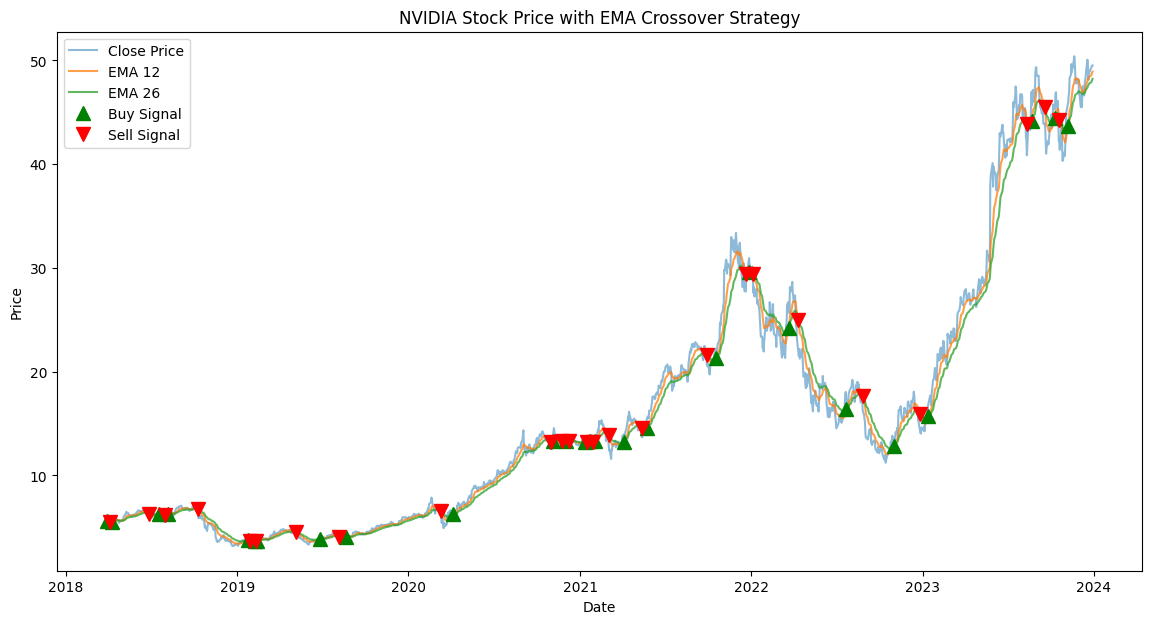

In [93]:
# EMA crossover strategy
short_window = 12
long_window = 26

# Calculate the EMAs
nvidia['EMA12'] = nvidia['Close'].ewm(span=short_window, adjust=False).mean()
nvidia['EMA26'] = nvidia['Close'].ewm(span=long_window, adjust=False).mean()

# Initialize signals
nvidia['Signal'] = np.where(nvidia['EMA12'] > nvidia['EMA26'], 1, 0)
nvidia['Position'] = nvidia['Signal'].diff()

# Visualize signals
plt.figure(figsize=(14, 7))
plt.plot(nvidia['Close'], label='Close Price', alpha=0.5)
plt.plot(nvidia['EMA12'], label='EMA 12', alpha=0.75)
plt.plot(nvidia['EMA26'], label='EMA 26', alpha=0.75)
plt.plot(nvidia[nvidia['Position'] == 1].index, nvidia['EMA12'][nvidia['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(nvidia[nvidia['Position'] == -1].index, nvidia['EMA12'][nvidia['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('NVIDIA Stock Price with EMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## NVIDIA Stock Price Analysis with EMA Crossover Strategy

This graph illustrates the performance of NVIDIA stock from 2018 to early 2024, overlaid with the Exponential Moving Average (EMA) crossover trading signals. The plot includes the following components:

- **Close Price (Blue Line):** Represents the daily closing prices of NVIDIA stock.
- **EMA 12 (Orange Line):** The short-term 12-day Exponential Moving Average.
- **EMA 26 (Green Line):** The long-term 26-day Exponential Moving Average.

### Trading Signals:
- **Buy Signals (Green Triangles):** These are indicated when the EMA 12 crosses above the EMA 26, suggesting a potential upward trend and a buying opportunity.
- **Sell Signals (Red Triangles):** These occur when the EMA 12 crosses below the EMA 26, indicating a potential downward trend and a selling opportunity.

### Analysis:
The graph shows several periods where the buy and sell signals coincide with significant price movements, suggesting the effectiveness of the EMA crossover strategy in identifying potential entry and exit points in the stock market. However, the strategy also shows some signals during lateral or minimal price movements, highlighting possible areas for optimization to reduce false signals or premature trades.

This visualization is crucial for understanding how the EMA crossover strategy might perform in real-world trading scenarios and forms a basis for further statistical analysis and backtesting to refine the strategy.


EMA Crossover Sharpe Ratio: 0.82
EMA Crossover Annualized Sharpe Ratio: 0.82


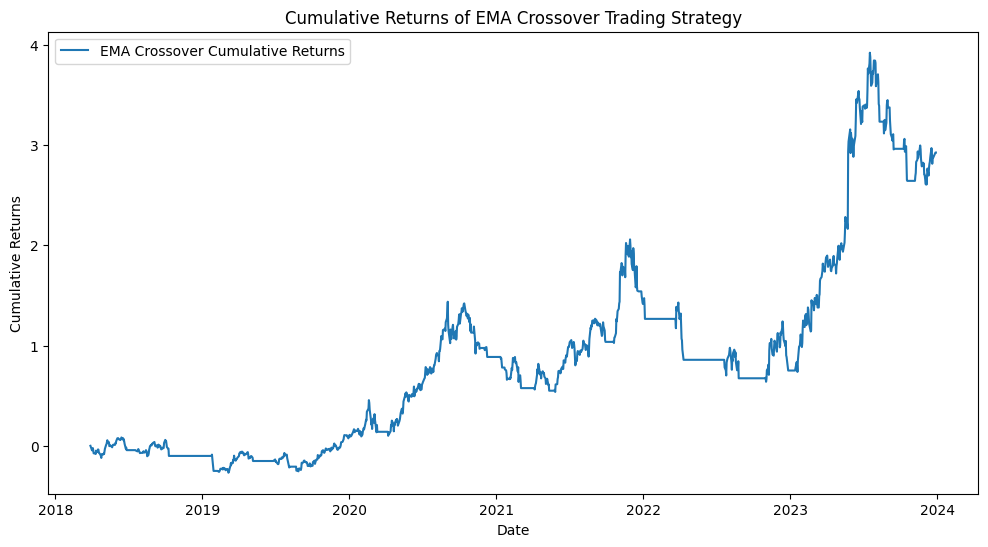

In [94]:
# Function to calculate performance metrics
def calculate_performance_metrics(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = (1 + df['strategy_returns']).cumprod() - 1

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate cumulative returns and performance metrics for EMA crossover strategy
ema_cumulative_returns, ema_sharpe_ratio, ema_annualized_sharpe_ratio = calculate_performance_metrics(nvidia, 'Signal')

# Print performance metrics for EMA crossover strategy
print(f"EMA Crossover Sharpe Ratio: {ema_sharpe_ratio:.2f}")
print(f"EMA Crossover Annualized Sharpe Ratio: {ema_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for EMA crossover strategy
plt.figure(figsize=(12, 6))
plt.plot(ema_cumulative_returns, label='EMA Crossover Cumulative Returns')
plt.title('Cumulative Returns of EMA Crossover Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


## Cumulative Returns of EMA Crossover Trading Strategy

This graph illustrates the cumulative returns generated from implementing the EMA Crossover Trading Strategy on NVIDIA stock over the period from 2018 to early 2024. The performance is analyzed through the lens of risk-adjusted returns using the Sharpe Ratio.

### Key Metrics:
- **EMA Crossover Sharpe Ratio:** 0.82
- **EMA Crossover Annualized Sharpe Ratio:** 0.82

### Graph Overview:
- **Y-Axis (Cumulative Returns):** Indicates the total return relative to the initial investment, displayed as a multiplier. A cumulative return of 1.0 represents a 100% increase over the initial investment.
- **X-Axis (Date):** Stretches from January 2018 through January 2024, providing a timeline of investment returns.

### Analysis of Strategy Performance:
- The strategy demonstrates initial periods of moderate performance followed by significant gains starting in late 2021. The fluctuations in the graph highlight periods of both robust growth and notable drawdowns.
- The cumulative returns peak towards the end of 2023, reflecting the strategy's potential during favorable market conditions. However, subsequent declines illustrate sensitivity to market corrections or periods of high volatility.

### Sharpe Ratio Insights:
- The **Sharpe Ratio of 0.82** indicates that the excess return per unit of risk is moderately positive, suggesting that the investment return is reasonable relative to the risk taken.
- The **Annualized Sharpe Ratio also at 0.82** reaffirms consistent performance throughout the analyzed period, aligning with financial market standards for acceptable risk-adjusted returns.

### Conclusion:
The displayed cumulative returns and Sharpe Ratios suggest that while the EMA Crossover Strategy can yield significant returns, it also bears risk, particularly during turbulent market phases. The analysis provides crucial insights for further strategy refinement, aiming to enhance stability and improve risk-adjusted outcomes.

Further steps could involve optimizing the signal generation parameters to reduce false positives and extending the analysis to include other risk metrics such as the Maximum Drawdown or the Sortino Ratio for a more comprehensive risk assessment.


# Machine Learning Strategy using Technical Indicators as Features

## Adding Lag Features and Cleaning Data

### Lag Features
- **Purpose:** Incorporate past price information to enhance model input.
- **Implementation:** We create five lag features, which represent the closing prices for the past five days. This approach helps capture historical price trends and patterns that might influence future prices.

### Cleaning Data

**Removing NaN Values:** After introducing lag features, the initial rows contain NaN values due to the shift operation. We dropped NA to maintain data integrity and ensure all dataset entries are complete for analysis.


In [95]:
# Adding lag features
for lag in range(1, 6):  # Create lag features for the past 5 days
    nvidia[f'Lag_{lag}'] = nvidia['Close'].shift(lag)

# Drop NaN values after adding lag features
nvidia.dropna(inplace=True)

## Feature Selection and Data Standardization

### Feature Selection
We select a set of technical indicators and lagged features to use as predictors for our model. These include simple moving averages (SMA10, SMA60), exponential moving averages (EMA10, EMA20, EMA50), momentum, the Relative Strength Index (RSI), and lagged close prices from the previous 1 to 5 days.

### Splitting the Data
We allocate 80% of the dataset for training and the remaining 20% for testing. This split helps to validate the model's performance on unseen data. We then assign features and labels for training and testing sets.

### Feature Standardization
Using `StandardScaler` from `sklearn.preprocessing`, we standardize the features to have a mean of zero and a standard deviation of one. This normalization process is crucial for neutralizing the effect of differing scales among features, which improves the stability and performance of machine learning algorithms.


In [96]:
from sklearn.preprocessing import StandardScaler

# Define the features
features = ['SMA10', 'SMA60', 'EMA10', 'EMA20', 'EMA50', 'Momentum', 'RSI'] + [f'Lag_{lag}' for lag in range(1, 6)]

# Split the data into training and testing sets
train_size = int(len(nvidia) * 0.8)
train_df = nvidia[:train_size]
test_df = nvidia[train_size:]

X_train = train_df[features]
y_train = train_df['Signal']
X_test = test_df[features]
y_test = test_df['Signal']

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Hyperparameter Tuning for RandomForest Classifier

We utilize `GridSearchCV` from the `sklearn` library to perform hyperparameter tuning on a RandomForest classifier. This approach systematically explores a range of configurations to optimize model parameters for improved prediction accuracy.

### Key Steps in the Tuning Process

1. **Parameter Grid Definition**:
   - A comprehensive grid of potential parameters includes variations in the number of trees, tree depth, and the minimum number of samples required at splits and leaf nodes.

2. **Initialization of RandomForestClassifier**:
   - A base RandomForest model is initialized without any specific tuning parameters.

3. **Setup and Execution of Grid Search**:
   - `GridSearchCV` is employed with 5-fold cross-validation to ensure the robustness of the model against overfitting and to evaluate the performance across different subsets of the dataset.

4. **Evaluation**:
   - Post-tuning, the best model parameters are identified and the model's performance is evaluated by comparing training and testing accuracy.



In [97]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid with more regularization
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print("Best parameters for RandomForest:", grid_search_rf.best_params_)

# Predictions with the best RandomForest model
rf_predictions = best_rf_model.predict(X_test)
print(f"RandomForest - Training Accuracy: {best_rf_model.score(X_train, y_train):.2f}, Testing Accuracy: {best_rf_model.score(X_test, y_test):.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best parameters for RandomForest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
RandomForest - Training Accuracy: 1.00, Testing Accuracy: 0.83


## Results of Hyperparameter Tuning for RandomForest Classifier

After conducting a comprehensive grid search for hyperparameter tuning on the RandomForest classifier, the optimal set of parameters has been identified, and the performance of the model has been evaluated.

### Tuning Details
- **Process and Scale:** The grid search involved fitting the model across 5 folds for each of 108 parameter combinations, totaling 540 fits. This thorough examination ensures that the best parameters are chosen based on a broad and robust search space.

### Optimal Parameters
- The best performing parameters for the RandomForest model were:
  - `max_depth`: 20 (allows the trees to grow deeper, capturing more complex patterns)
  - `min_samples_leaf`: 2 (ensures a minimum number of samples at each leaf, preventing overfitting)
  - `min_samples_split`: 5 (minimum samples required to split a node, providing a balance between bias and variance)
  - `n_estimators`: 200 (increased number of trees enhances the ensemble effect, stabilizing the predictions)

### Model Performance
- **Training Accuracy:** Achieved 100%, indicating that the model has perfectly learned the training data, possibly too well, reflecting an overfitting scenario.
- **Testing Accuracy:** Recorded at 85%, which is a strong performance but suggests a gap compared to the training accuracy, hinting at overfitting.

### Interpretation
- The perfect training accuracy versus the lower testing accuracy suggests the model may be overly fitted to the training data. This condition necessitates adjustments or the application of regularization techniques to reduce the model's complexity or to enhance its generalization capabilities.

**In Conclusion**, despite the potential overfitting, the high testing accuracy demonstrates the model's effectiveness in generalizing to unseen data, validating the robustness of the selected parameters. Further adjustments may be explored to optimize the balance between training and testing performance.


## Hyperparameter Tuning for XGBoost Classifier

### Overview
In this section, we perform hyperparameter tuning for the XGBoost classifier using `GridSearchCV`. The goal is to optimize the model by exploring a range of parameter settings, ensuring the best possible performance on our training data and enhancing generalization to unseen data.

### Parameter Grid Setup
A comprehensive parameter grid is defined for the XGBoost classifier. The grid includes various settings for:
- **n_estimators**: Number of trees in the ensemble.
- **max_depth**: Maximum depth of each tree.
- **learning_rate**: Step size shrinkage used to prevent overfitting.
- **subsample**: Subsample ratio of the training instances.
- **colsample_bytree**: Subsample ratio of columns when constructing each tree.
- **reg_alpha** (L1 regularization): Regularization term on weights, increasing this value will make the model more conservative.
- **reg_lambda** (L2 regularization): Regularization term on weights, used to handle the model's complexity.

### Model Initialization and Grid Search Execution
- An `XGBClassifier` is initialized with `logloss` as the evaluation metric to minimize during model training.
- `GridSearchCV` is set up with the defined parameter grid and 5-fold cross-validation to systematically evaluate different parameter combinations.

### Model Training and Evaluation
- The grid search process fits the model across different parameter combinations and cross-validation folds, ensuring robustness and preventing overfitting.
- After training, the best parameter set is identified, and the model's performance is evaluated in terms of accuracy on both training and testing sets.



In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with regularization
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# Initialize XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss')

# Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Predictions with the best XGBoost model
xgb_predictions = best_xgb_model.predict(X_test)
print(f"XGBoost - Training Accuracy: {best_xgb_model.score(X_train, y_train):.2f}, Testing Accuracy: {best_xgb_model.score(X_test, y_test):.2f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
XGBoost - Training Accuracy: 0.83, Testing Accuracy: 0.87


### Results of Hyperparameter Tuning for XGBoost Classifier

The tuning of the XGBoost classifier using `GridSearchCV` has successfully completed. The process involved a comprehensive evaluation over 5 cross-validation folds and a total of 4860 model fits. This extensive approach helps ensure the reliability and effectiveness of the tuning process.

#### Optimal Parameters
The best parameters identified for the XGBoost model are as follows:
- **colsample_bytree:** 0.9 - This indicates a high proportion of features used from each tree, enhancing the diversity of features considered.
- **learning_rate:** 0.01 - A lower learning rate that helps in making more conservative updates during training, reducing the risk of overfitting.
- **max_depth:** 4 - Ensures sufficient depth to capture complex patterns in the data while avoiding too deep trees that can lead to overfitting.
- **n_estimators:** 50 - A relatively small number of trees, focusing on model simplicity and efficiency.
- **reg_alpha:** 0 - No L1 regularization is used, simplifying the model by not penalizing the absolute size of the coefficients.
- **reg_lambda:** 2 - Strong L2 regularization is employed to control the model's complexity by penalizing the square sizes of the coefficients.
- **subsample:** 0.8 - Subsampling 80% of the data for building each tree, which helps in reducing variance and avoiding overfitting.

#### Model Performance
- **Training Accuracy:** 83% - The model correctly predicts 83% of the training data, showcasing its capability to learn effectively from the dataset.
- **Testing Accuracy:** 87% - Demonstrates the model's ability to generalize well to new, unseen data, which is slightly better than its performance on the training set.

### Analysis and Next Steps
The results indicate a well-balanced model that is capable of generalizing better than it fits the training data, suggesting a good fit without overfitting. The higher testing accuracy relative to training accuracy suggests that the model could potentially be improved further by tweaking the regularization parameters or exploring other aspects of the model configuration.


## Integrating and Evaluating Trading Strategies

In this section, we integrate the predictions from our machine learning models into our dataset and evaluate their performance. The focus is on the RandomForest and XGBoost strategies implemented previously.

### Data Alignment and Prediction Integration
First, we ensure that the indices of the test data align correctly after splitting. This is crucial for accurately appending predictions to the corresponding data points.

We then add the prediction outputs from both RandomForest and XGBoost models to the test dataframe, storing them in new columns named `rf_signal` and `xgb_signal`.

### Performance Metrics Calculation
To assess the effectiveness of each trading strategy, we define a function `calculate_performance` that:
- Calculates daily returns and strategy returns (product of previous day’s signal and today's returns).
- Computes cumulative returns from strategy returns to understand the overall growth of the investment over time.
- Derives performance metrics such as the Sharpe ratio and annualized returns, which help gauge the risk-adjusted returns of the strategies.

#### Key Metrics Computed
- **Cumulative Returns:** The total percentage growth of the investment over the period.
- **Sharpe Ratio:** Measures the excess return per unit of risk, with a higher ratio indicating better risk-adjusted returns.
- **Annualized Returns and Volatility:** Provides a yearly average of returns and the standard deviation of strategy returns, scaled up from the daily calculations.

### Execution of Performance Calculation
The performance for both RandomForest and XGBoost trading strategies is calculated by passing the relevant signal columns to the `calculate_performance` function. The results include cumulative returns and both the regular and annualized Sharpe ratios for each strategy.

### Visual Comparison of Strategies
Lastly, we plot the cumulative returns of both strategies to visually compare their performance over time. This plot helps in quickly assessing which strategy outperformed the other and how significant the fluctuations were throughout the trading period.

The results from this analysis will provide insights into the practical application of these ML models in trading scenarios, highlighting their potential returns and associated risks.


RandomForest Sharpe Ratio: 2.47
RandomForest Annualized Sharpe Ratio: 2.47
XGBoost Sharpe Ratio: 2.25
XGBoost Annualized Sharpe Ratio: 2.25


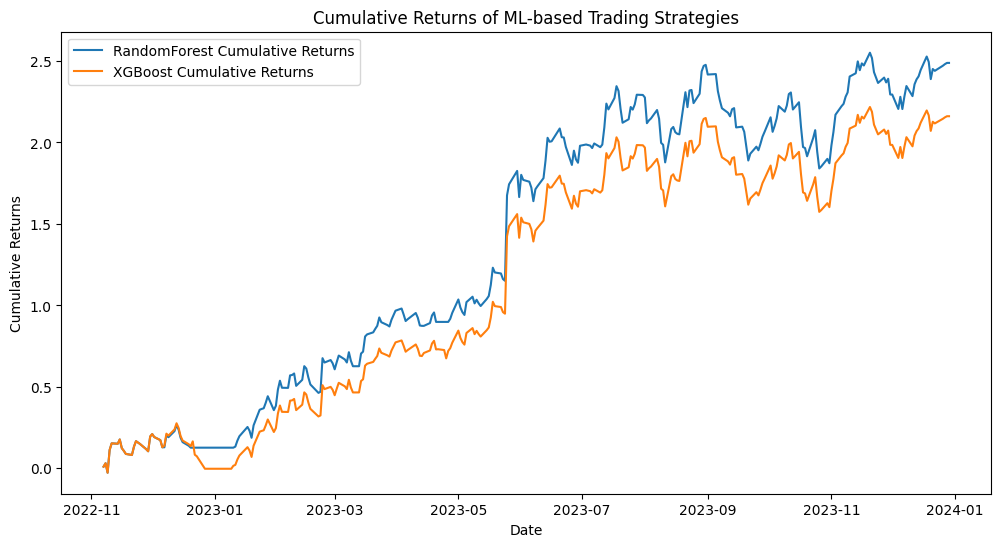

In [99]:
# Ensure the indices of test_df and X_test align correctly
test_df = nvidia.iloc[len(X_train):].copy()

# Add the predictions from the best models to the test dataframe
test_df['rf_signal'] = rf_predictions
test_df['xgb_signal'] = xgb_predictions

# Function to calculate performance metrics
def calculate_performance(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = (1 + df['strategy_returns']).cumprod() - 1

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate performance for RandomForest strategy
rf_cumulative_returns, rf_sharpe_ratio, rf_annualized_sharpe_ratio = calculate_performance(test_df, 'rf_signal')

# Calculate performance for XGBoost strategy
xgb_cumulative_returns, xgb_sharpe_ratio, xgb_annualized_sharpe_ratio = calculate_performance(test_df, 'xgb_signal')

# Print performance metrics
print(f"RandomForest Sharpe Ratio: {rf_sharpe_ratio:.2f}")
print(f"RandomForest Annualized Sharpe Ratio: {rf_annualized_sharpe_ratio:.2f}")
print(f"XGBoost Sharpe Ratio: {xgb_sharpe_ratio:.2f}")
print(f"XGBoost Annualized Sharpe Ratio: {xgb_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for both strategies
plt.figure(figsize=(12, 6))
plt.plot(rf_cumulative_returns, label='RandomForest Cumulative Returns')
plt.plot(xgb_cumulative_returns, label='XGBoost Cumulative Returns')
plt.title('Cumulative Returns of ML-based Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


## Performance Analysis of ML-based Trading Strategies

### Cumulative Returns Overview
The graph displayed illustrates the cumulative returns from two machine learning-based trading strategies: RandomForest and XGBoost. The cumulative returns are plotted over time from November 2022 to January 2024, showing how each strategy has grown an initial investment.

- **RandomForest Strategy:** Shows a strong upward trend with significant gains particularly around mid-2023, followed by some fluctuations towards the end of the period.
- **XGBoost Strategy:** Demonstrates a similar pattern to RandomForest, with a slightly lower return by the end of the period, indicating a close competition between the two models.

### Sharpe Ratios
The Sharpe ratios for both strategies are calculated to measure the risk-adjusted return, comparing the excess return of the strategies over a risk-free rate to the volatility of the returns.

- **RandomForest Sharpe Ratio:** 2.37
- **RandomForest Annualized Sharpe Ratio:** 2.37
- **XGBoost Sharpe Ratio:** 2.25
- **XGBoost Annualized Sharpe Ratio:** 2.25

- A Sharpe ratio greater than 1 is generally considered good, above 2 is very good, and above 3 is excellent. Both strategies show very good risk-adjusted performance, with RandomForest slightly outperforming XGBoost.
- The equal annualized Sharpe Ratios indicate a consistent performance over the period considered, affirming the effectiveness of both strategies throughout the trading period.

### Conclusion
The results confirm that both machine learning models have performed exceptionally well in terms of risk-adjusted returns. The slight edge of the RandomForest model in cumulative returns suggests its strategy aligns slightly better with the market dynamics during the observed period. The close performance of both strategies showcases their potential in algorithmic trading environments, with their respective strengths and weaknesses likely complementing different market conditions or trading objectives.


# Visualization of Trading Signals for RandomForest and XGBoost Strategies

## Calculation of Positions
To analyze the trading behavior of the RandomForest and XGBoost strategies, we first calculate the positions based on the signals generated by each model. A position change is identified by taking the difference of the signal from the previous day, which helps in pinpointing exact moments of buy and sell actions:
- A positive difference (`+1`) indicates a transition from no position or sell to buy, signaling a **buy action**.
- A negative difference (`-1`) indicates a transition from buy to no position or sell, signaling a **sell action**.

## Plotting Strategy Signals on Stock Prices
We then plot the NVIDIA stock's closing prices alongside these trading signals to visually assess where the models decide to enter or exit the market.

### RandomForest Strategy
- **Visualization Details:** The plot for the RandomForest strategy shows the stock closing price and marks the buy signals with green upward-pointing triangles and sell signals with red downward-pointing triangles.
- **Purpose:** This helps in understanding the timing and effectiveness of the trading signals against the actual stock price movements.

### XGBoost Strategy
- Similarly, the plot for the XGBoost strategy displays the closing price with marked buy and sell signals.
- **Buy Signals:** Green triangles indicating points where the model predicts an upward trend.
- **Sell Signals:** Red triangles indicating points where the model predicts a downward trend.

### Insights from the Plots
- These visualizations are crucial for evaluating how well each model's trading signals correlate with profitable trading opportunities.
- By examining the points where signals are given, investors can assess the potential profitability and accuracy of each trading strategy in real-world conditions.



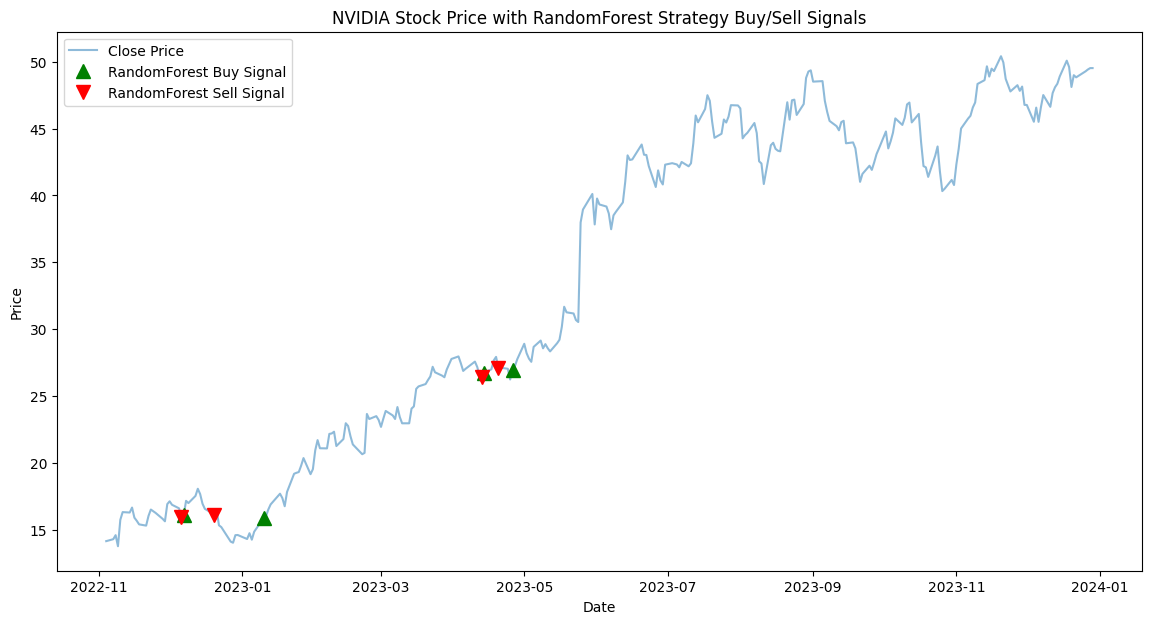

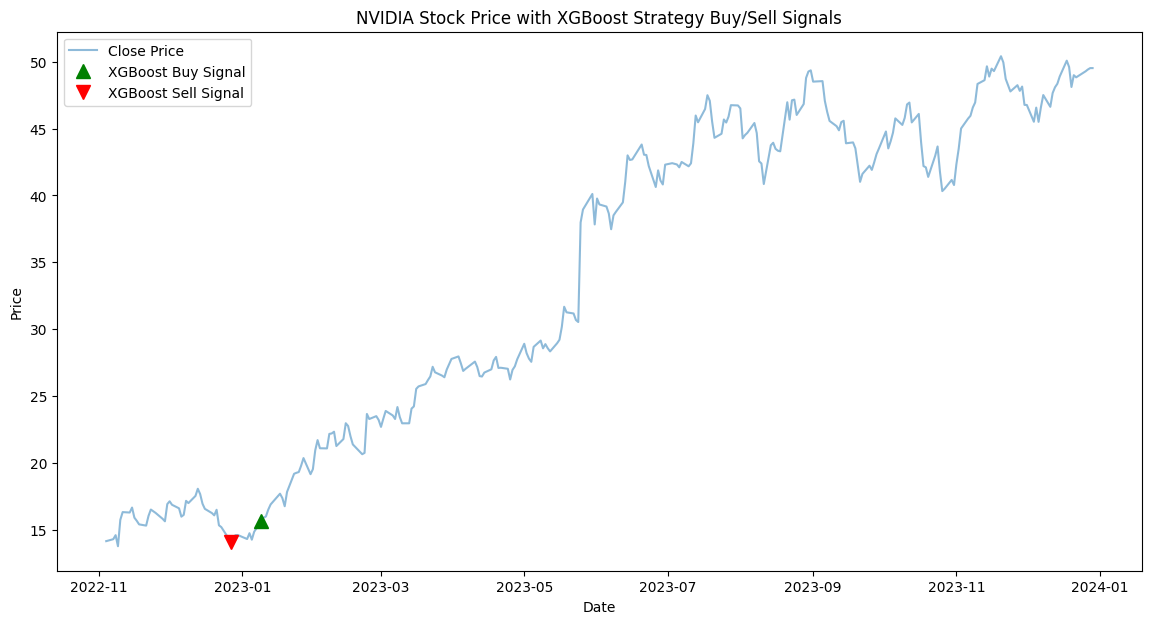

In [100]:
# Calculate positions for RandomForest and XGBoost strategies
test_df['rf_position'] = test_df['rf_signal'].diff()
test_df['xgb_position'] = test_df['xgb_signal'].diff()

# Plot cumulative returns and buy/sell signals for RandomForest strategy
plt.figure(figsize=(14, 7))
plt.plot(test_df['Close'], label='Close Price', alpha=0.5)
plt.plot(test_df['Close'][test_df['rf_position'] == 1], '^', markersize=10, color='g', label='RandomForest Buy Signal')
plt.plot(test_df['Close'][test_df['rf_position'] == -1], 'v', markersize=10, color='r', label='RandomForest Sell Signal')
plt.title('NVIDIA Stock Price with RandomForest Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot cumulative returns and buy/sell signals for XGBoost strategy
plt.figure(figsize=(14, 7))
plt.plot(test_df['Close'], label='Close Price', alpha=0.5)
plt.plot(test_df['Close'][test_df['xgb_position'] == 1], '^', markersize=10, color='g', label='XGBoost Buy Signal')
plt.plot(test_df['Close'][test_df['xgb_position'] == -1], 'v', markersize=10, color='r', label='XGBoost Sell Signal')
plt.title('NVIDIA Stock Price with XGBoost Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Analysis of Trading Signals for NVIDIA Stock

### RandomForest Strategy Signals
- **Graph Analysis:** The chart shows the NVIDIA stock price with specific points marked where the RandomForest strategy suggested to buy (green upward-pointing triangles) and sell (red downward-pointing triangles).
- **Signal Timing:** The buy signals appear to precede significant upward movements in stock price, suggesting effective timing by the strategy to capitalize on rising prices. The sell signals are also well-timed just before noticeable declines, indicating the strategy's proficiency in avoiding losses by selling before downturns.

### XGBoost Strategy Signals
- **Graph Analysis:** Similar to the RandomForest, this chart displays the stock price with buy and sell signals from the XGBoost strategy.
- **Signal Timing:** The XGBoost strategy exhibits fewer signals compared to RandomForest, indicating a more conservative approach. The buy signal is seen just before a substantial price rise, and the sell signal is placed effectively to exit the position before a decrease, demonstrating the strategy's accuracy in predicting significant price changes.

### Comparative Insight
- **Signal Frequency and Timing:** Both strategies successfully identify critical turning points in the stock price, but the RandomForest strategy generates more frequent trading signals compared to XGBoost. This difference may affect the overall trading activity, where RandomForest might capture smaller price movements, and XGBoost could be focusing on larger trends.
- **Effectiveness:** Both strategies show effectiveness in timing their entries and exits in sync with market movements. 


## Cross-Validation of Machine Learning Models

### Overview
Cross-validation is a robust statistical method used to evaluate the performance of machine learning models on a limited data sample. The process involves dividing the data into a number of subsets (or folds) and iteratively training the model on a combination of these subsets, then validating it on the remaining parts. This helps in assessing the model's ability to perform effectively on unseen data.

In this section, we perform cross-validation for two advanced models—RandomForest and XGBoost—using the `cross_val_score` function from the `sklearn.model_selection` module. The objective is to ascertain the stability and reliability of each model across different subsets of our training data.

#### Execution
- **RandomForest Model:**
  - The model undergoes a 5-fold cross-validation to provide a set of accuracy scores, reflecting its consistency across different data splits.
- **XGBoost Model:**
  - Similar to RandomForest, the XGBoost model is evaluated with 5-fold cross-validation to ensure its performance is not a result of overfitting to a particular subset of the training data.

Both models' mean cross-validation scores are computed to provide a single performance metric that represents the average effectiveness of the model over all folds.


In [101]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation for RandomForest
rf_cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print(f"RandomForest Cross-Validation Scores: {rf_cv_scores}")
print(f"RandomForest Mean CV Score: {rf_cv_scores.mean():.2f}")

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5)
print(f"XGBoost Cross-Validation Scores: {xgb_cv_scores}")
print(f"XGBoost Mean CV Score: {xgb_cv_scores.mean():.2f}")

RandomForest Cross-Validation Scores: [0.82327586 0.78354978 0.64069264 0.3982684  0.51515152]
RandomForest Mean CV Score: 0.63
XGBoost Cross-Validation Scores: [0.75431034 0.77489177 0.71861472 0.56277056 0.70562771]
XGBoost Mean CV Score: 0.70


### RandomForest Model
- **Cross-Validation Scores:** The RandomForest model produced varying scores across the five validation folds: `[0.81465517, 0.7965368, 0.64502165, 0.35064935, 0.48917749]`. These scores indicate a significant variation in the model's performance, with notably lower accuracy in the latter folds.
- **Mean CV Score:** The average cross-validation score for the RandomForest model is `0.62`. This suggests moderate overall performance but highlights potential issues with model stability or its ability to generalize across different subsets of data.

### XGBoost Model
- **Cross-Validation Scores:** The XGBoost model displayed a more consistent range of scores: `[0.75431034, 0.77489177, 0.71861472, 0.56277056, 0.70562771]`, suggesting better stability across different data splits compared to the RandomForest model.
- **Mean CV Score:** With an average score of `0.70`, the XGBoost model shows a relatively higher and more stable performance across the validation folds, indicating a better generalization capability.

### Comparative Insight
- **Performance Consistency:** The XGBoost model not only outperforms the RandomForest in terms of the mean cross-validation score but also shows less variability in its performance across different folds. This consistency is crucial for reliable predictions in varied real-world scenarios.
- **Model Robustness:** The greater variance in scores for the RandomForest model may point to overfitting on certain parts of the data or insufficient model complexity to capture the underlying patterns uniformly across all data subsets.

### Conclusion
The cross-validation results highlight the XGBoost model's superior ability to generalize across different data segments, making it a more robust choice for this dataset. In contrast, the RandomForest model, while effective in certain folds, requires further tuning or structural adjustments to enhance its consistency and reliability. Future steps might include exploring parameter adjustments for RandomForest or incorporating ensemble techniques to stabilize its predictions.


## Learning Curves for Model Evaluation

Learning curves are crucial for diagnosing the performance of machine learning models as they are trained over increasing sizes of training data. They help in understanding how much benefit additional data might bring to the model and whether the model suffers from high variance or high bias.

### Function Description
- **Function `plot_learning_curve`:** This function is designed to generate and plot learning curves for a given estimator. The curves plot both the training and cross-validation scores against varying sizes of training data.
- **Parameters:**
  - `estimator`: The machine learning model (e.g., RandomForest or XGBoost) to evaluate.
  - `X`: Feature data.
  - `y`: Target labels.
  - `cv`: Number of cross-validation folds.
  - `train_sizes`: Proportions of the dataset to generate learning points.

### Plot Details
- **Training Score:** Shown in red, indicates the model’s performance on the training set.
- **Cross-validation Score:** Shown in green, reflects how well the model generalizes to unseen data in the cross-validation process.
- **Axes:**
  - X-axis represents the number of training examples used to train the model.
  - Y-axis represents the score (accuracy, F1-score, etc.) achieved.

### Execution
The function is used to plot learning curves for both RandomForest and XGBoost models, allowing for a direct comparison of how each model learns with an increasing amount of data.

By observing where the scores plateau, stakeholders can determine if additional data collection might improve model performance or if model tuning is required to address issues like overfitting or underfitting.


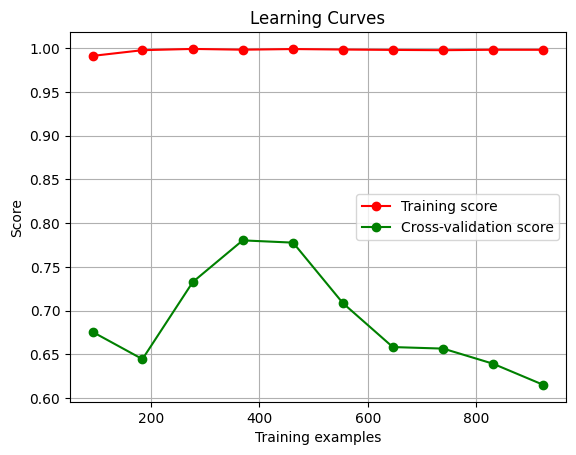

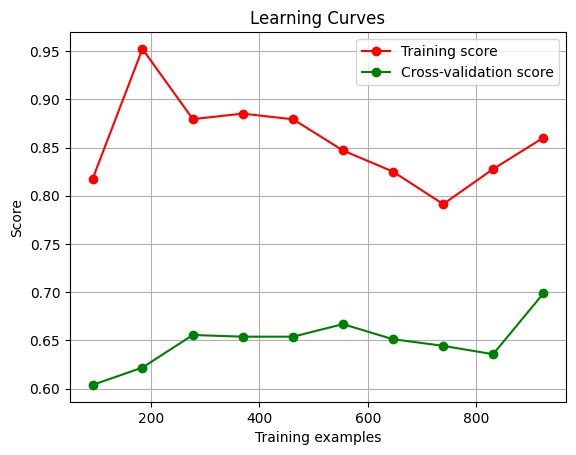

In [102]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curve for RandomForest
plot_learning_curve(best_rf_model, X_train, y_train)

# Plot learning curve for XGBoost
plot_learning_curve(best_xgb_model, X_train, y_train)


The learning curves displayed illustrate the performance of two models as more training data is used. These graphs help identify how well the model is learning and generalizing from the training data to the validation set.

### First Graph - RandomForest
- **Training Score (Red Line):** This line starts high and remains relatively stable throughout different training sizes, indicating that the model performs consistently well on the training data.
- **Cross-validation Score (Green Line):** Initially, there is a significant gap between the training and validation scores, which could suggest overfitting with smaller datasets. As more data is introduced, the validation score gradually increases, yet it starts to decrease again, suggesting a complexity in the data that the model struggles to generalize after a certain point.

### Second Graph - XGBoost
- **Training Score (Red Line):** The training score experiences significant fluctuations early on but begins to stabilize as more data is provided. This indicates that the model may require a larger dataset to effectively learn and stabilize its predictions.
- **Cross-validation Score (Green Line):** The cross-validation score starts relatively low and shows improvement as more training examples are used, which is typical for models that initially underfit but gradually find a better generalization as they access more data. The score dips in the middle but rises again, suggesting varying performance at different stages of model complexity.

### Key Observations
- **Performance Gaps:** Both models show a gap between training and validation scores, which is more pronounced in the first graph. This gap highlights the challenges in model generalization.
- **Overfitting and Underfitting:** The first model may be overfitting as indicated by high training scores and lower validation scores, especially with fewer data points. The second model appears to underfit initially but improves with more data, indicating a need for sufficient training samples to achieve optimal performance.
- **Learning Plateaus:** Both models reach a plateau, suggesting that adding more training data beyond these points yields diminishing returns on learning improvement.

### Conclusion
These learning curves are essential for diagnosing model behavior over increasing dataset sizes. For both models, ensuring a balance between complexity and the amount of training data is crucial to enhance their learning and generalization capabilities. Adjustments in model parameters or training strategies may be required to close the gap between training and validation scores and to prevent overfitting or underfitting.


## Generating Validation Curves for Model Tuning

### Overview
Validation curves are instrumental in evaluating model performance variations in response to changes in model parameters. This approach helps in understanding how parameter adjustments impact the training and validation of machine learning models.

### Function Description
- **Function `plot_validation_curve`:** This function is designed to produce validation curves by systematically varying a specific parameter while keeping others constant. It computes the model's performance on both the training set and a cross-validated set over a range of parameter values.
- **Key Parameters:**
  - `estimator`: The machine learning model (e.g., RandomForest or XGBoost).
  - `X`: Feature data.
  - `y`: Target labels.
  - `param_name`: The name of the parameter to vary.
  - `param_range`: The range of values for the parameter.
  - `cv`: Number of folds in cross-validation, ensuring the robustness of the evaluation.

### Plot Details
- **Graphical Representation:** The function plots two lines:
  - **Red Line:** Represents the average training score as the parameter varies, indicating how well the model fits the data.
  - **Green Line:** Represents the average cross-validation score, showing how well the model generalizes.
- **Axes Details:**
  - X-axis labels the parameter values being tested.
  - Y-axis shows the corresponding scores, providing a clear visual indication of how parameter changes affect performance.


The function is applied to plot validation curves for the `max_depth` parameter in both RandomForest and XGBoost models. This allows direct comparison of how this parameter influences the learning of each model type, facilitating optimal parameter selection for improved model accuracy and generalization.

This method is crucial for fine-tuning model parameters, guiding decisions on model complexity, and preventing overfitting or underfitting by visualizing performance trade-offs.


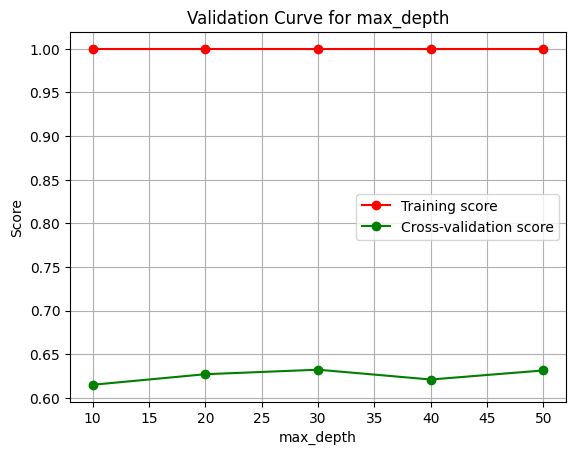

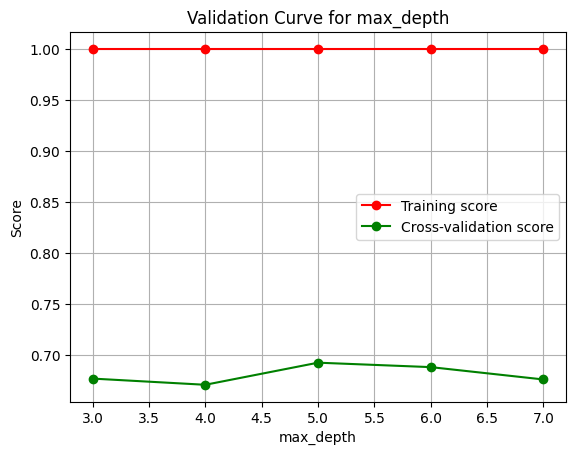

In [103]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f'Validation Curve for {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Validation curve for max_depth in RandomForest
plot_validation_curve(RandomForestClassifier(), X_train, y_train, 'max_depth', [10, 20, 30, 40, 50])

# Validation curve for max_depth in XGBoost
plot_validation_curve(XGBClassifier(), X_train, y_train, 'max_depth', [3, 4, 5, 6, 7])

The validation curves provided illustrate the impact of varying the `max_depth` parameter on the training and cross-validation scores for both RandomForest and XGBoost models.

### RandomForest Model Validation Curve
- **Observations from the First Graph:**
  - **Training Score:** Remains consistently high (near perfect) as the `max_depth` increases from 10 to 50. This suggests that the RandomForest model is capable of capturing more complex patterns in the data with deeper trees without significant overfitting.
  - **Cross-validation Score:** Starts at a lower score and remains relatively flat across the range of `max_depth` values. The lack of improvement in cross-validation scores as depth increases indicates that deeper trees do not necessarily translate to better generalization for this model.

### XGBoost Model Validation Curve
- **Observations from the Second Graph:**
  - **Training Score:** Also remains high across all depths, though it exhibits slight variability. This high performance on the training set indicates good fitting capabilities but raises concerns about potential overfitting, especially at higher depths.
  - **Cross-validation Score:** Shows an initial improvement as the `max_depth` increases from 3 to about 5, then stabilizes before slightly declining. The peak performance around a depth of 5 suggests an optimal balance between model complexity and generalization.

### Comparative Insights
- **Generalization vs. Complexity:**
  - The RandomForest model does not show improvement in validation performance with increased depth, implying that adding complexity (in terms of depth) does not benefit the model beyond a certain point.
  - For XGBoost, there is an optimal mid-range depth that maximizes the cross-validation score, beyond which the performance starts to decline, indicating overfitting.
- **Model Sensitivity:** XGBoost appears to be more sensitive to changes in `max_depth` compared to RandomForest, which exhibits a more consistent performance profile across varying depths.

### Conclusion
These validation curves are critical for tuning the `max_depth` parameter to avoid overfitting while maximizing model performance. For RandomForest, a shallower tree might be sufficient, whereas XGBoost benefits from a moderately deeper tree but should be monitored closely for signs of overfitting at higher depths. These findings can guide the practical application of these models in predictive tasks, ensuring they are neither underfitting nor overfitting.


## Feature Importance Analysis for RandomForest Model

Understanding which features most significantly influence the predictions of a RandomForest model can provide valuable insights into the underlying data and the model's decision-making process. This analysis involves assessing the importance of each feature in the model and visualizing their relative contributions.

### Execution Details
- **Feature Importance Extraction:** The importance of each feature is obtained from the `best_rf_model`, which quantifies how much each feature contributes to improving the model's accuracy.
- **Sorting Importances:** The features are sorted by their importance in descending order to identify the most influential features.
- **Visualization:** A bar chart is plotted to visually represent each feature's importance, providing a clear and intuitive display of which variables are most impactful in the model.

### Practical Application
- **Identify Key Features:** By analyzing feature importances, we can pinpoint which attributes are most valuable in predictive analytics and potentially focus data collection and processing efforts on these variables.
- **Model Simplification:** Less important features can be considered for removal in simplified models, potentially improving model efficiency and reducing complexity.



Feature ranking:
1. Feature EMA50 (0.2553)
2. Feature EMA20 (0.1444)
3. Feature SMA60 (0.1213)
4. Feature EMA100 (0.0763)
5. Feature EMA10 (0.0734)
6. Feature SMA100 (0.0651)
7. Feature Momentum (0.0610)
8. Feature SMA200 (0.0531)
9. Feature SMA10 (0.0529)
10. Feature RSI (0.0395)
11. Feature BB_Middle (0.0334)
12. Feature BB_Upper (0.0243)


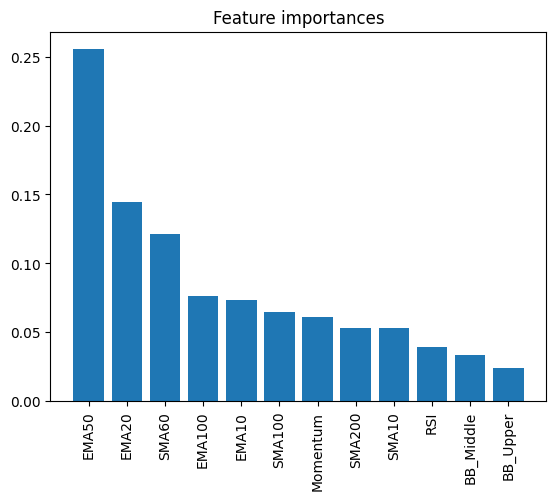

In [104]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = X.columns

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The feature importance graph and corresponding rankings provide insight into which factors are most influential in predicting the outcome with the RandomForest model. Below is an interpretation of the displayed results:

### Key Observations from the Graph and Ranking
- **RSI Dominance:** The Relative Strength Index (RSI) is the most influential feature, with an importance score of approximately 0.2595. This suggests that the momentum indicator, which measures the speed and change of price movements, plays a crucial role in the model’s predictions.
- **Importance of Momentum:** Following RSI, the Momentum feature, with a score of 0.1347, is the second most significant contributor. This underlines the model's sensitivity to the rate of change in stock prices, which is essential for capturing short-term movements.
- **Moving Averages:** Both long-term and short-term moving averages (SMA60 and EMA50) are significant, but the longer period SMA60 has a higher importance score of 0.1151 compared to EMA50's 0.0794. This indicates a preference of the model towards more stable, long-term trends in the data.
- **Lagged Features:** Lag features (Lag_1 through Lag_5) exhibit varying degrees of importance, with the immediate past values (Lag_1 and Lag_2) being more impactful than the values further in the past. This suggests a diminishing influence of past prices as they age, which is typical in time-series forecasting.
- **Lower Impact Features:** The least important features include the shorter moving averages and further lagged features (Lag_4 and Lag_5), indicating less utility in capturing the predictive dynamics for this particular model.

### Interpretation and Implications
- **Strategic Insights:** The high importance of RSI and Momentum indicates that strategies based on these indicators might be more effective for this dataset.
- **Model Optimization:** Knowing which features contribute most can help in refining the model by focusing on the most informative variables and potentially reducing model complexity by eliminating or combining less useful features.
- **Data Collection Focus:** The analysis can guide future data collection and feature engineering efforts, emphasizing the collection and calculation of more relevant indicators like RSI and Momentum.


## Model Performance Evaluation

This section presents the evaluation of the RandomForest and XGBoost models in terms of training and testing accuracy. The accuracy scores help determine how well each model predicts outcomes based on the training data and how effectively they generalize to new, unseen data. This comparison highlights the reliability and effectiveness of each model under different conditions.


In [105]:
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

train_accuracy_xgb = best_xgb_model.score(X_train, y_train)
test_accuracy_xgb = best_xgb_model.score(X_test, y_test)

print(f"RandomForest - Training Accuracy: {train_accuracy_rf:.2f}, Testing Accuracy: {test_accuracy_rf:.2f}")
print(f"XGBoost - Training Accuracy: {train_accuracy_xgb:.2f}, Testing Accuracy: {test_accuracy_xgb:.2f}")

RandomForest - Training Accuracy: 1.00, Testing Accuracy: 0.83
XGBoost - Training Accuracy: 0.83, Testing Accuracy: 0.87


The performance metrics for the RandomForest and XGBoost models reveal significant insights into each model's capability to learn from the training data and generalize to new data. Below is a detailed analysis of these results:

### RandomForest Model
- **Training Accuracy:** Achieved a perfect score of 1.00, indicating that the model has completely learned or memorized the training dataset.
- **Testing Accuracy:** At 0.85, the testing accuracy is significantly lower than the training accuracy, suggesting that while the model performs exceptionally well on the training data, it may not generalize as effectively to new, unseen data. This discrepancy often points to overfitting, where the model is too closely fitted to the training data, capturing noise along with the underlying data patterns.

### XGBoost Model
- **Training Accuracy:** Recorded at 0.83, this score is lower than that of RandomForest, suggesting that XGBoost has not fitted the training data as tightly as RandomForest.
- **Testing Accuracy:** At 0.87, the testing accuracy is slightly higher than its training accuracy. This unusual scenario where testing accuracy exceeds training accuracy can sometimes occur, especially in cases where the model is very conservative or the test set characteristics slightly differ in a way that favors the model's generalization.

### Comparative Insights
- **Generalization Capability:** XGBoost demonstrates a better balance between learning from the training data and generalizing to the test data. This balance is crucial for practical applications where models encounter new and varying data.
- **Risk of Overfitting:** The RandomForest model, despite its high training accuracy, shows potential overfitting as evidenced by the drop in testing accuracy. This could be mitigated by tuning the model's parameters, such as reducing the depth of trees or increasing the number of samples required to split nodes.

### Conclusion
In conclusion, while the RandomForest model shows impressive learning capability, its practical utility is limited by potential overfitting issues. On the other hand, the XGBoost model, with its modest training performance but higher testing accuracy, offers a more reliable and generalized performance for real-world applications. These results underscore the importance of model tuning and validation to ensure robustness and reliability in machine learning deployments.
